In [1]:
#from Preprocess import train_dataset, val_dataset, test_dataset, amazon_training_image_paths, amazon_validation_image_paths, amazon_test_image_paths, batches

import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Activation, LeakyReLU, Dropout, Input, Lambda, Add, Conv2DTranspose, Concatenate, Reshape, Permute, Multiply, GlobalAveragePooling2D, Dense, Flatten

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score
import tensorflow.keras.backend as K
#from hyperparameters import alpha
K.set_image_data_format('channels_last')
from tensorflow.keras.models import Model

In [2]:
import _models_utils
from tensorflow.keras import callbacks
from datetime import datetime
import os

# -------------------- Cargar los datos con o sin augmentación

use_augmentation = True  # Variable para decidir si se usa augmentación de datos
training_data, validation_data, testing_data = _models_utils.load_datasets(use_augmentation=use_augmentation)

# ----------- Crear directorios para guardar resultados

# Definimos un directorio de salida basado en la fecha y hora actual
output_directory = '../results/' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '_UNET_ATTN/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    os.makedirs(os.path.join(output_directory, 'plots'))
    os.makedirs(os.path.join(output_directory, 'weights'))
    os.makedirs(os.path.join(output_directory, 'predictions'))

# Configuración de callback para guardar los mejores pesos durante el entrenamiento
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=os.path.join(output_directory, 'weights', 'model.{epoch:02d}-{val_loss:.4f}.weights.h5'),
    save_weights_only=True,   # Guardar solo los pesos del modelo
    save_best_only=True,      # Guardar solo los mejores pesos (según val_accuracy)
    monitor='val_accuracy',   # Métrica monitoreada para guardar los pesos
    mode='max',               # Modo de monitoreo ('max' para maximizar la val_accuracy)
    verbose=1                 # Nivel de verbosidad para la consola
)


In [3]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Add, Concatenate, Lambda, Activation, UpSampling2D, Multiply
from tensorflow.keras import backend as K

def conv2d_block(input_tensor, filters, kernel_size=3, apply_batchnorm=True, stride=1, dilation=1, recurrence=1):
    """
    Construye un bloque Conv2D para ser usado en capas de downsampling en una red convolucional.

    Parámetros:
    -----------
    input_tensor : tensor
        Tensor de entrada para la capa Conv2D.
    filters : int
        Número de filtros en la capa Conv2D.
    kernel_size : int, opcional
        Tamaño del kernel para la convolución (por defecto 3).
    apply_batchnorm : bool, opcional
        Si se aplica o no Batch Normalization (por defecto True).
    stride : int, opcional
        Tamaño del paso de la convolución (por defecto 1).
    dilation : int, opcional
        Tasa de dilación en la convolución (por defecto 1).
    recurrence : int, opcional
        Número de iteraciones recurrentes del bloque de convolución.

    Retorna:
    --------
    tensor
        Salida de la capa después de la convolución, Batch Normalization y activación.
    """
    conv_layer = Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, kernel_initializer="he_normal", padding="same", dilation_rate=dilation)(input_tensor)
    if apply_batchnorm:
        conv_layer = BatchNormalization()(conv_layer)
    output_layer = LeakyReLU(alpha=0.3)(conv_layer)

    for _ in range(recurrence - 1):
        conv_layer = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, kernel_initializer="he_normal", padding="same", dilation_rate=dilation)(output_layer)
        if apply_batchnorm:
            conv_layer = BatchNormalization()(conv_layer)
        recurrent_output = LeakyReLU(alpha=0.3)(conv_layer)
        output_layer = Add()([output_layer, recurrent_output])

    return output_layer

def upsample_block(input_tensor, skip_tensor, filters, kernel_size=3, stride=1, apply_batchnorm=True, recurrence=1):
    """
    Bloque de upsampling usando Conv2DTranspose para las capas de upsampling en una red convolucional.

    Parámetros:
    -----------
    input_tensor : tensor
        Tensor de entrada para el upsampling.
    skip_tensor : tensor
        Tensor de conexión de salto.
    filters : int
        Número de filtros en la capa Conv2DTranspose.
    kernel_size : int, opcional
        Tamaño del kernel para la convolución (por defecto 3).
    stride : int, opcional
        Tamaño del paso para la convolución transpuesta (por defecto 1).
    apply_batchnorm : bool, opcional
        Si se aplica o no Batch Normalization (por defecto True).
    recurrence : int, opcional
        Número de iteraciones recurrentes en el bloque.

    Retorna:
    --------
    tensor
        Salida del bloque de upsampling concatenada con el tensor de salto.
    """
    input_shape = K.int_shape(input_tensor)
    skip_shape = K.int_shape(skip_tensor)

    upsample_layer = Conv2DTranspose(filters=filters, kernel_size=kernel_size, padding='same', strides=(skip_shape[1] // input_shape[1], skip_shape[2] // input_shape[2]), kernel_initializer="he_normal")(input_tensor)
    upsample_layer = LeakyReLU(alpha=0.3)(upsample_layer)

    act_layer = conv2d_block(upsample_layer, filters=filters, kernel_size=kernel_size, stride=1, apply_batchnorm=apply_batchnorm, dilation=1, recurrence=recurrence)
    output_layer = Concatenate(axis=3)([act_layer, skip_tensor])
    return output_layer

def expand_dimension(tensor, repeat_factor):
    """
    Expande un tensor en el eje especificado.

    Parámetros:
    -----------
    tensor : tensor
        Tensor de entrada para expandir.
    repeat_factor : int
        Factor de repetición en el eje especificado.

    Retorna:
    --------
    tensor
        Tensor expandido en el eje especificado.
    """
    expanded_tensor = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': repeat_factor})(tensor)
    return expanded_tensor

def attention_gate(x, gating_signal, inter_shape):
    """
    Bloque de atención para recalibrar el tensor de entrada basado en una señal de control.

    Parámetros:
    -----------
    x : tensor
        Tensor de entrada al bloque de atención.
    gating_signal : tensor
        Señal de control para el gating.
    inter_shape : int
        Número de filtros intermedios.

    Retorna:
    --------
    tensor
        Salida del bloque de atención ajustada.
    """
    x_shape = K.int_shape(x)
    gating_shape = K.int_shape(gating_signal)

    # Ajustamos la señal de gating al número de filtros de la capa intermedia
    gated_signal = Conv2D(filters=inter_shape, kernel_size=1, strides=1, padding='same')(gating_signal)

    # Ajustamos el tensor de entrada a la misma forma que la señal de gating
    x_adjusted = Conv2D(filters=inter_shape, kernel_size=3, strides=(x_shape[1] // gating_shape[1], x_shape[2] // gating_shape[2]), padding='same')(x)

    # Suma de la señal de gating y el tensor de entrada
    combined_signal = Add()([gated_signal, x_adjusted])
    combined_signal = Activation('relu')(combined_signal)

    # Convolución 1x1x1 y activación sigmoid
    attention_weights = Conv2D(filters=1, kernel_size=1, padding='same')(combined_signal)
    attention_weights = Activation('sigmoid')(attention_weights)

    # Upsampling para devolver el tamaño a las dimensiones originales
    attention_weights = UpSampling2D(size=(x_shape[1] // K.int_shape(attention_weights)[1], x_shape[2] // K.int_shape(attention_weights)[2]))(attention_weights)
    attention_weights = expand_dimension(attention_weights, x_shape[3])

    # Multiplicación de coeficientes de atención con el tensor original
    recalibrated_signal = Multiply()([attention_weights, x])

    # Convolución final para ajustar la salida
    output_signal = Conv2D(filters=x_shape[3], kernel_size=1, strides=1, padding='same')(recalibrated_signal)
    output_signal = BatchNormalization()(output_signal)
    return output_signal

def gating_signal(input_tensor, apply_batchnorm=True):
    """
    Genera una señal de gating consolidada con un filtro 1x1x1.

    Parámetros:
    -----------
    input_tensor : tensor
        Tensor de entrada al bloque de gating.
    apply_batchnorm : bool, opcional
        Si se aplica o no Batch Normalization (por defecto True).

    Retorna:
    --------
    tensor
        Salida del bloque de gating con el gating consolidado.
    """
    input_shape = K.int_shape(input_tensor)
    gated_layer = Conv2D(filters=input_shape[3], kernel_size=1, strides=1, padding="same", kernel_initializer="he_normal")(input_tensor)
    if apply_batchnorm:
        gated_layer = BatchNormalization()(gated_layer)
    gated_output = LeakyReLU(alpha=0.3)(gated_layer)
    return gated_output


In [4]:

def attention_unet(input_shape, base_filters=16, apply_batchnorm=True):
    """
    Construye un modelo Attention U-Net para segmentación de imágenes con bloques de atención.

    Parámetros:
    -----------
    input_shape : tuple
        Dimensiones de entrada de la imagen (altura, ancho, canales).
    base_filters : int, opcional
        Número de filtros base en la primera capa (por defecto 16).
    apply_batchnorm : bool, opcional
        Si se aplica o no Batch Normalization en las capas convolucionales (por defecto True).

    Retorna:
    --------
    model : tf.keras.Model
        Modelo Attention U-Net construido.
    """

    inputs = tf.keras.Input(input_shape)
    
    # Encoder (Codificación)
    
    encoder_block0 = conv2d_block(inputs, filters=base_filters, kernel_size=3, apply_batchnorm=apply_batchnorm, stride=1, dilation=1, recurrence=2)  # 256x256xbase_filters
    pool0 = MaxPooling2D((2,2))(encoder_block0)
    pool0 = Dropout(0.4)(pool0)
    
    encoder_block1 = conv2d_block(pool0, filters=base_filters * 2, kernel_size=3, apply_batchnorm=apply_batchnorm, stride=1, dilation=1, recurrence=2)  # 128x128x(base_filters*2)
    pool1 = MaxPooling2D((2,2))(encoder_block1)
    pool1 = Dropout(0.4)(pool1)
    
    encoder_block2 = conv2d_block(pool1, filters=base_filters * 4, kernel_size=3, apply_batchnorm=apply_batchnorm, stride=1, dilation=1, recurrence=2)  # 64x64x(base_filters*4)
    pool2 = MaxPooling2D((2,2))(encoder_block2)
    pool2 = Dropout(0.4)(pool2)

    encoder_block3 = conv2d_block(pool2, filters=base_filters * 8, kernel_size=3, apply_batchnorm=apply_batchnorm, stride=1, dilation=1, recurrence=2)  # 32x32x(base_filters*8)
    pool3 = MaxPooling2D((2,2))(encoder_block3)
    pool3 = Dropout(0.4)(pool3)

    # Bridge (Puente)
    
    bridge_block = conv2d_block(pool3, filters=base_filters * 16, kernel_size=3, apply_batchnorm=apply_batchnorm, stride=1, dilation=1, recurrence=2)  # 16x16x(base_filters*16)

    # Decoder (Decodificación) con bloques de atención
    
    attn_gate0 = attention_gate(encoder_block3, bridge_block, base_filters * 16)
    upsample_block0 = upsample_block(bridge_block, attn_gate0, filters=base_filters * 8, apply_batchnorm=apply_batchnorm, recurrence=2)  # 32x32x(base_filters*8)

    attn_gate1 = attention_gate(encoder_block2, upsample_block0, base_filters * 8)
    upsample_block1 = upsample_block(upsample_block0, attn_gate1, filters=base_filters * 4, apply_batchnorm=apply_batchnorm, recurrence=2)  # 64x64x(base_filters*4)

    attn_gate2 = attention_gate(encoder_block1, upsample_block1, base_filters * 4)
    upsample_block2 = upsample_block(upsample_block1, attn_gate2, filters=base_filters * 2, apply_batchnorm=apply_batchnorm, recurrence=2)  # 128x128x(base_filters*2)

    upsample_block3 = upsample_block(upsample_block2, encoder_block0, filters=base_filters, apply_batchnorm=apply_batchnorm, recurrence=2)  # 256x256xbase_filters

    # Capa de salida
    outputs = Conv2D(filters=1, kernel_size=1, strides=1, activation='sigmoid')(upsample_block3)
    model = Model(inputs=inputs, outputs=[outputs])
    
    return model

In [5]:
# Definir la forma de entrada de las imágenes
input_dimensions = (256, 256, 4)  # Imagen de 256x256 con 4 canales

# Crear el modelo Attention U-Net con normalización por lotes activada
attention_unet_model = attention_unet(input_dimensions, apply_batchnorm=True)

# Compilar el modelo especificando el optimizador, la función de pérdida y las métricas
attention_unet_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                             loss='binary_crossentropy', 
                             metrics=['accuracy'])

# Definir el número de épocas de entrenamiento
num_epochs = 20

# Entrenar el modelo con el conjunto de datos de entrenamiento y validación, usando callbacks
training_history = attention_unet_model.fit(
    training_data, 
    epochs=num_epochs, 
    validation_data=validation_data, 
    callbacks=[checkpoint_callback]
)


Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.8565
Epoch 1: val_accuracy improved from -inf to 0.92671, saving model to ../results/2024-11-11_20-25-46_UNET_ATTN/weights\model.01-0.3434.weights.h5
125/125 [==============================] - 30s 193ms/step - loss: 0.3264 - accuracy: 0.8565 - val_loss: 0.3434 - val_accuracy: 0.9267
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.8801
Epoch 2: val_accuracy did not improve from 0.92671
125/125 [==============================] - 23s 184ms/step - loss: 0.2799 - accuracy: 0.8801 - val_loss: 0.2866 - val_accuracy: 0.8777
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.8854
Epoch 3: val_accuracy did not improve from 0.92671
125/125 [==============================] - 24s 193ms/step - loss: 0.2674 - accuracy: 0.8854 - val_loss: 0.1948 - val_accuracy: 0.9216
Epoch 4/20
125/125 [==============================] - ETA: 0s -

In [6]:
# ---------------------- Guardar resultados

# Cargar el modelo más reciente guardado de forma dinámica
import glob
import os

try:
    # Buscar todos los archivos de pesos en la carpeta 'weights'
    weights_files = glob.glob(os.path.join(output_directory, 'weights', '*.weights.h5'))
    
    if weights_files:
        # Seleccionar el archivo más reciente basado en la fecha de creación o modificación
        most_recent_weights = max(weights_files, key=os.path.getctime)
        print(f"Cargando los pesos más recientes desde: {most_recent_weights}")
        
        # Cargar los pesos en el modelo
        attention_unet_model.load_weights(most_recent_weights)
        print("Pesos cargados exitosamente.")
    else:
        # Si no se encuentran archivos de pesos, se informa al usuario
        print("No se encontraron archivos de pesos en el directorio especificado.")
except FileNotFoundError:
    # Manejo específico para el error de archivo no encontrado
    print("No se encontró el archivo de pesos. Verifica la ruta o el nombre del archivo.")
except Exception as error:
    # Manejo general para cualquier otra excepción
    print(f"Ocurrió un error al cargar los pesos: {str(error)}")


Cargando los pesos más recientes desde: ../results/2024-11-11_20-25-46_UNET_ATTN/weights\model.19-0.0809.weights.h5
Pesos cargados exitosamente.


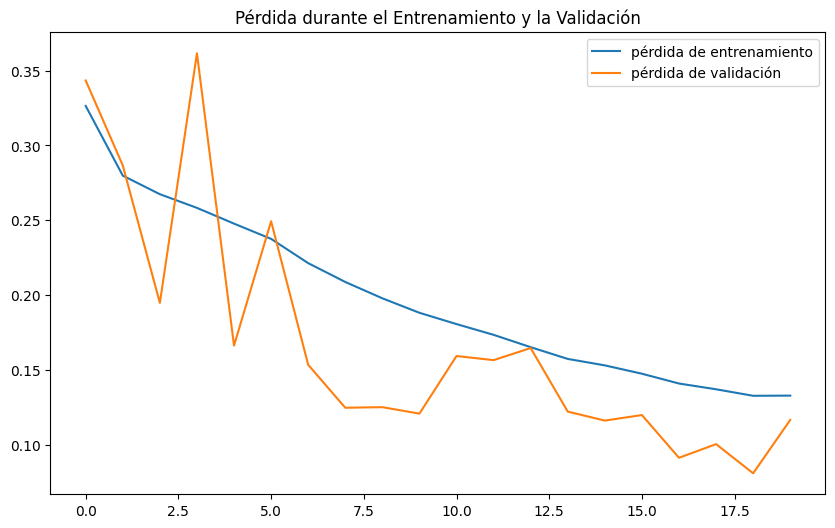

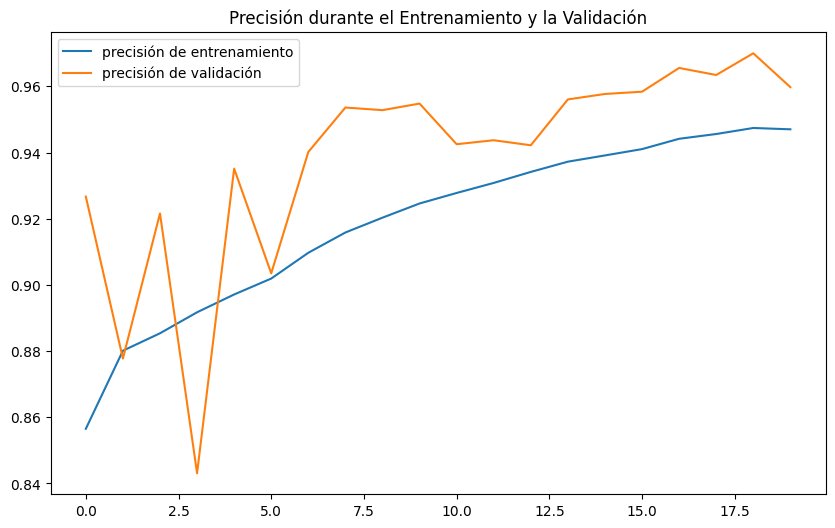

In [7]:

# Graficamos la pérdida (loss) del entrenamiento y la validación
plt.figure(figsize=(10, 6))
plt.plot(training_history.history['loss'], label='pérdida de entrenamiento')  # Gráfica de la pérdida en entrenamiento
plt.plot(training_history.history['val_loss'], label='pérdida de validación')  # Gráfica de la pérdida en validación
plt.title('Pérdida durante el Entrenamiento y la Validación')
plt.legend()

# Guardamos la gráfica de pérdida en el directorio correspondiente
plt.savefig(os.path.join(output_directory, 'plots', 'loss.png'))
plt.show()

# Graficamos la precisión (accuracy) del entrenamiento y la validación
plt.figure(figsize=(10, 6))
plt.plot(training_history.history['accuracy'], label='precisión de entrenamiento')  # Gráfica de la precisión en entrenamiento
plt.plot(training_history.history['val_accuracy'], label='precisión de validación')  # Gráfica de la precisión en validación
plt.title('Precisión durante el Entrenamiento y la Validación')
plt.legend()

# Guardamos la gráfica de precisión en el directorio correspondiente
plt.savefig(os.path.join(output_directory, 'plots', 'accuracy.png'))
plt.show()

In [8]:
# ---------------------- Guardar el modelo y generar predicciones

from _models_utils import show_and_save_predictions

# Guardar el modelo completo en formato .h5
final_model_path = os.path.join(output_directory, 'weights', 'final_model.h5')
attention_unet_model.save(final_model_path)
print(f"Modelo guardado exitosamente en: {final_model_path}")

# Generar y guardar predicciones para los primeros 80 ejemplos del conjunto de prueba
num_predictions = 80  # Número de predicciones a generar
for idx in range(num_predictions):
    show_and_save_predictions(idx, testing_data, attention_unet_model, output_directory)


Modelo guardado exitosamente en: ../results/2024-11-11_20-25-46_UNET_ATTN/weights\final_model.h5
1/1 [==============================] - 0s 33ms/step


In [10]:
# ----------- Guardar métricas del modelo

import _models_utils

# Configuración de parámetros de augmentación en caso de que esté activada
if use_augmentation:
    augmentation_parameters = {
        "flip_left_right": 0,
        "flip_up_down": 0,
        "gaussian_blur": 0.2,
        "random_noise": 0.0,
        "random_brightness": 0.5,
        "random_contrast": 0.5
    }
else:
    augmentation_parameters = None

batch_size = 16
is_shuffled = True

# Evaluar el modelo con los parámetros definidos y almacenar la información en un DataFrame
model_metrics = _models_utils.evaluate_model(
    description="U-net attention; final dataset", 
    test_data=testing_data,
    model=attention_unet_model, 
    input_shape=input_dimensions, 
    is_shuffled=is_shuffled, 
    batch_size=batch_size, 
    epochs_num=num_epochs, 
    augment_settings=augmentation_parameters, 
    threshold=0.5
)

# Guardar las métricas del modelo en un archivo CSV
metrics_df = pd.DataFrame(model_metrics)
metrics_df.to_csv(os.path.join(output_directory, 'metrics.csv'), index=False)
print(f"Métricas guardadas exitosamente en: {os.path.join(output_directory, 'metrics.csv')}")


1/1 [==============================] - 0s 34ms/step
Métricas guardadas exitosamente en: ../results/2024-11-11_20-25-46_UNET_ATTN/metrics.csv
